In [1]:
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 
import scipy.io

---------------------- SCIANN 0.5.4.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



# Introduction
This is the code for the Navier-Stokes inversion problem from SciANN paper:
+ https://arxiv.org/abs/2005.08803
+ https://www.sciencedirect.com/science/article/pii/S0045782520307374

The training data can be found in the following repository:
+ https://github.com/maziarraissi/PINNs/tree/master/main/Data/cylinder_nektar_wake.mat

In [2]:
def PrepareData(num_data=5000, random=True):
    
    # Get data file from: 
    #         https://github.com/maziarraissi/PINNs/tree/master/main/Data/cylinder_nektar_wake.mat
    data = scipy.io.loadmat('cylinder_nektar_wake.mat')
    
    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T
    
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)

In [3]:
x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(5000, random=True)

# PINN setup 

As discussed in the paper, the independent variables are $(x,y,t)$ and the solution variables are $(p, \psi)$. The velocities are defined as $u=\psi_{,y}$ and $v=-\psi_{,x}$. 

The neural networks are:
$$
p: (x,y,t) \rightarrow \mathcal{N}_p(x,y,t; \mathbf{W}, \mathbf{b})
\psi: (x,y,t) \rightarrow \mathcal{N}_{\psi}(x,y,t; \mathbf{W}, \mathbf{b})
$$


The governing relations are summerized as:
$$
u_{,t} + p_{,x} + \lambda_1 (u u_{,x} + v u_{,y}) - \lambda_2 (u_{,xx} + u_{,yy}) = 0 \\
v_{,t} + p_{,y} + \lambda_1 (u v_{,x} + v v_{,y}) - \lambda_2 (v_{,xx} + v_{,yy}) = 0 
$$



Define independent variables with `sn.Variable`:

In [23]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

Define solution variables with `sn.Functional` (multi-layer neural network):

In [24]:
P = sn.Functional("P", [x, y, t], 8*[20], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], 8*[20], 'tanh')

For inversion, define parameters using `sn.Parameter`:

In [25]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

Use `sn.diff` and other mathematical operations to set up the PINN model. 

In [26]:
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

Define targets (losses) using `sn.Data`, `sn.Tie`, and `sn.PDE` interfaces. 

In [27]:
# Define constraints 
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P)

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)

Keras <= 1.4.0 requires training on every target. Therefore, it will through an error if we do not train on $\psi$. 

To resolve this error, let's add a trivial target for $\psi$: 

In [28]:
c4 = Psi*0.0

Define the optimization model with `sn.SciModel`:

In [29]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse",
    plot_to_file='NS-Model.png'
)

The network is plotted in the NS-Model.png file. 

![SciModel](NS-Model.png)

Prepare the training data according to the order they are defined in `sn.SciModel`. 

In [30]:
input_data = [x_train, y_train, t_train]

In [31]:
data_d1 = u_train
data_d2 = v_train
data_d3 = p_train
data_c1 = 'zeros'
data_c2 = 'zeros'
data_c3 = 'zeros'
data_c4 = 'zeros'
target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

Train the model by calling `.train` function. Check the documentation at www.sciann.com for all the training options. 

In [32]:
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs=10000,
    batch_size=100,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)

model.save_weights('trained-navier-stokes.hdf5')

In [33]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))

lambda1: [0.99794099],  lambda2: [0.0108588]


Text(0, 0.5, 'loss')

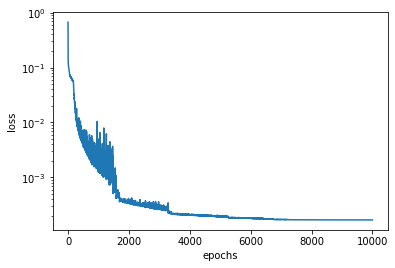

In [34]:
plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')